# Rapprochement

In [25]:
import csv
import json
import time
from batid.utils.misc import is_float
from batid.services.pairing_bdgs import pair

In [46]:
# ##############
# Define utilities

def rowToParams(row) -> dict: 
    
    address_infos = [row["Numéro, type et nom de la voie"], row["Code postal"], row["Commune Nom"]]
    address_infos = [info for info in address_infos if info is not None]
    
    return {
        'ext_id': row["Numéro de l'équipement sportif"],
        'name': row["Nom de l'installation sportive"],
        'address': ", ".join(address_infos),
        'lat': float(row['Latitude (WGS84)']) if is_float(row['Latitude (WGS84)']) else None,
        'lng': float(row['Longitude (WGS84)']) if is_float(row['Longitude (WGS84)']) else None,
        'radius': 100
    }

def results_to_report(results) -> dict:
    report = {}
    for ext_id, result_row in results.items():
        report_row = result_row
        if result_row['result'] is not None:
            report_row['result'] = {
                'rnb_id': report_row['result'].rnb_id,
                'distance': report_row['result'].distance.m,
                'point': f"{report_row['result'].point[1]},{report_row['result'].point[0]}"
            }
        report[ext_id] = report_row
    
    return report

# #########
# Le rapprochement

start = time.perf_counter()
with open('data/data-es.csv') as f:
    reader = csv.DictReader(f, delimiter=';')
    raw = list(reader)

    data = []
    for row in raw:
        params = rowToParams(row)
        if params['lat'] and params['lng']:
            data.append(params)
    
results = pair(data, 'closest')
report = results_to_report(results)

        
with open('results/closest.json', 'w') as f:
    json.dump(report, f)
    
elapsed = time.perf_counter() - start


print('-- Fini --')
print(f"Lignes CSV : {len(raw)}")
print(f"Rapprochement tentés : {len(data)}")
print(f"Temps passé {elapsed:02f} secondes")
print(f"Temps moyen par ligne : {elapsed / len(raw)} secondes")




-- Fini --
Lignes CSV : 86082
Rapprochement tentés : 85298
Temps passé 547.777550 secondes
Temps moyen par ligne : 0.006363438926918516 secondes


# Report

-- Total rows in original csv
86082
-- Rows with pairing try
85298
-- Distance = 0
42015
-- Distance <= 1
46897
-- Hist --
[[<Axes: title={'center': 'r_distance'}>]]


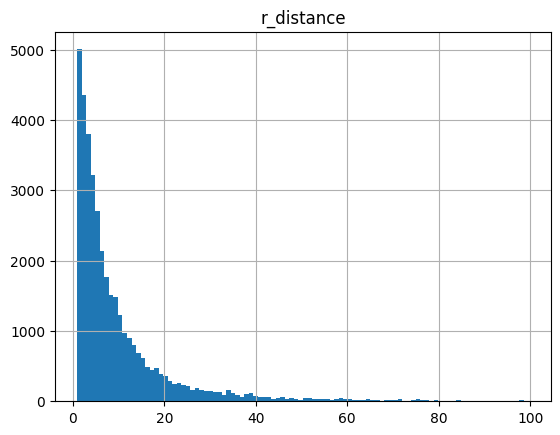

In [56]:
import pandas as pd
from pprint import pprint

with open('data/data-es.csv') as f:
    reader = csv.DictReader(f, delimiter=';')
    raw_count = len(list(reader))


with open('results/closest.json', 'r') as f:
    report = json.load(f)
    
data = []
for ext_id, row in report.items():
    
    data.append({
        'q_ext_id': ext_id,
        'q_latlng': f"{row['params']['lat']},{row['params']['lng']}",
        'q_address': row['params']['address'],
        'q_name': row['params']['name'],
        'r_rnb_id': row['result']['rnb_id'] if row['result'] is not None else None,
        'r_distance': row['result']['distance'] if row['result'] is not None else None,
        'r_point': row['result']['point'] if row['result'] is not None else None
    })
    
df = pd.DataFrame(data)


print('-- Total rows in original csv')
print(raw_count)

print('-- Rows with pairing try')
print(len(rows))

print('-- Distance = 0')
print((df["r_distance"] == 0).sum())

print('-- Distance <= 1')
print((df["r_distance"] <= 1).sum())

print('-- Hist --')
print(df[df['r_distance'] > 1].hist(bins=100))


## Echantillon des trop loin

In [43]:
size = 10
filtered_df = df[df['r_distance'] >= 10].head(size)

filtered_df

,q_ext_id,q_latlng,q_address,q_name,r_rnb_id,r_distance
0,E001I010330015,"46.1258,5.81417","27 Avenue du Stade, 01200, Valserhône",PISCINE MUNICIPALE,5HPR4CF5YJRZ,39.285457
3,E005I010530052,"46.2095,5.24029","Allée du Centre Nautique, 01000, Bourg-en-Bresse",Centre nautique Carré d'eau,18MTY7BQ968B,38.063581
5,E009I010320002,"45.84723,5.12445","68 RA d'Afrique La Valbonne, 01360, Béligneux",Camp Militaire,98YTG3TEG4ZA,10.846857
10,E001I010330022,"46.12222,5.8075","Rue Jean MALET, 01200, Valserhône",BOULODROME MUNICIPAL,YZEKYMHHQBYE,31.082028
13,E001I011850003,"45.9713,5.5958","185 Chemin des Lésines, 01110, Plateau d'Haute...",CENTRE EUROPEEN DE SECOURS ET STAGES SPORTIFS ...,CPYB7FFWYP1V,67.851072
17,E001I010340014,"45.75667,5.68528","Rue de l'Amitié, 01300, Belley",SALLE DE L'AMITIE,KR1RN76QYAHG,10.924910
22,E004I010320009,"45.853157,5.118853","501 chemin de bruyeres, 01360, Béligneux",LES CAVALIERS EN HERBE,FDVH1N4H4K1V,29.669927
26,E002I010330022,"46.12222,5.8075","Rue Jean MALET, 01200, Valserhône",BOULODROME MUNICIPAL,YZEKYMHHQBYE,31.082028
31,E001I011440001,"46.33622,4.99057","La Ville, 01380, Bâgé-Dommartin",GROUPE SCOLAIRE,CGK2RXXPKJSM,12.646214
32,E001I011350009,"46.285419,6.027527","269 CHEMIN DES HIVOUETTES, 01170, Crozet",Les Poneys de massoran,DVZACZH8JKKG,16.823594
